# Loading the dataset from the google drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Loading the Libraries:

In [2]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img,save_img

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import Concatenate
from keras.layers import ZeroPadding2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pathlib
#from preprocessing.visualize_prepro import shiftedColorMap
import itertools 
from timeit import timeit
import tensorflow as tf
import PIL.Image
from keras.preprocessing import image

Using TensorFlow backend.


# Here we assigning the paths for both imagess and masks:

As we are doing the Image segmentation we need to do work on the boundaries of the data set so we are converting the images to the grayscale this will reduce the load on the CPU and RAM and help to get the better result.

In [ ]:
path = '/content/drive/My Drive/TongeImageDataset-master/TongeImageDataset'
# input image dimensions
img_rows, img_cols = 128, 128
# output image dimensions
label_rows, label_cols = 128, 128
classes = ['dataset', 'mask1']

#for i in range(n_images):
    #label = 'mask1'
    #os.makedirs(os.path.join(directory, label), exist_ok=True)
    #filename = os.path.join(directory, label, str(i) + '.bmp')
    #save_img(filename, np.ones((128,128,3)))

   # we create two instances with the same arguments
img_data_gen_args = dict(
        # featurewise_center=True,
        # featurewise_std_normalization=True,
        rescale=1. / 255,
        fill_mode="constant",
        cval=0
    )
label_data_gen_args = dict(
        fill_mode="constant",
        cval=1
    )
image_datagen = ImageDataGenerator(**img_data_gen_args)
mask_datagen = ImageDataGenerator(**label_data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
    # image_datagen.fit(images, augment=True, seed=seed)
    # mask_datagen.fit(masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
        '/content/drive/My Drive/TongeImageDataset-master/TongeImageDataset',
        target_size=(img_rows, img_cols),
        class_mode=None,
        batch_size=8,
        shuffle=False,
        seed=seed)

mask_generator = mask_datagen.flow_from_directory(
        '/content/drive/My Drive/TongeImageDataset-master/masks',
        target_size=(label_rows, label_cols),
        class_mode=None,
        batch_size=8,
        shuffle=False,
        color_mode='grayscale',
        seed=seed)

    # combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

  

Found 301 images belonging to 1 classes.
Found 301 images belonging to 1 classes.


# MODEL:

Here we are using the U-Net model as it has both contraction and extraction path and you can refer to the site
LINK:http://deeplearning.net/tutorial/unet.html#:~:text=U%2DNet%20is%20a%20Fully,for%20classification%20and%20segmentation%20tasks.


![alt text](http://deeplearning.net/tutorial/_images/unet.jpg)

In [ ]:
  kernel = 3
  filter_size = 64
  pad = 1
  pool_size = 2

  model = Sequential()

  model.add(Layer(input_shape=(img_rows, img_cols, 1)))
    # encoding layers
  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))

    # decoding layers
  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())

  model.add(UpSampling2D(size=(pool_size, pool_size)))
  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())

  model.add(UpSampling2D(size=(pool_size, pool_size)))
  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())

  model.add(UpSampling2D(size=(pool_size, pool_size)))
  model.add(ZeroPadding2D(padding=(pad, pad)))
  model.add(Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
  model.add(BatchNormalization())

  model.add(Convolution2D(1, 1, 1, border_mode='valid',))
  print(model.output_shape)
  model.add(Reshape((label_rows * label_cols,)))
  model.add(Activation('sigmoid'))

  model.add(Reshape((label_rows, label_cols, 1)))
  model.compile(loss="binary_crossentropy", optimizer='adam',
                  metrics=['binary_accuracy'])
 
  model.summary()
    
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` c

(None, 128, 128, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 128, 128, 1)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 130, 130, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), padding="valid")`


# Here I have converted the Images to array for better computation:

In [ ]:
import tqdm
def load_image_mask(
    image_path='/content/drive/My Drive/TongeImageDataset-master/TongeImageDataset/dataset',
    mask_path='/content/drive/My Drive/TongeImageDataset-master/masks/mask1'
    ):
  import pathlib
  X = []
  y = []
  path_dir = pathlib.Path(image_path)
  imgs = sorted(list(path_dir.glob("*.bmp")))
  for i in tqdm.tqdm(range(301)):
    x_1 = image.load_img(image_path + "/" + str(i) + ".bmp", target_size=(128, 128))
    x_1 = image.img_to_array(x_1)
    x_1 = np.expand_dims(x_1, axis=0)
    X.append(x_1)
  for i in tqdm.tqdm(range(301)):
    y_1 = image.load_img(mask_path + "/" + str(i) + ".bmp", target_size=(128, 128))
    y_1 = image.img_to_array(y_1)
    y_1 = np.expand_dims(y_1, axis=0)
    y.append(y_1)
  return X, y


In [ ]:
X, y = load_image_mask()

100%|██████████| 301/301 [00:00<00:00, 308.17it/s]


In [ ]:
Have saved those arrays:

In [ ]:
X_1 = np.concatenate(X, axis=0)
y_1 = np.concatenate(y, axis=0)
np.save("Image1.npy", X_1)
np.save("Mask1.npy", y_1)
!cp "Image1.npy" "/content/drive/My Drive/"
!cp "Mask1.npy" "/content/drive/My Drive/"

Created model and trained:

In [ ]:
model.fit(X_1, y_1, batch_size=64, epochs=500)
model.save("model_2.model")
!cp "model_2.model" "/content/drive/My Drive/"
#model.save("New_model.model")
#!cp "New_model.model" "/content/drive/My Drive/"

As it is segmentaiton few no of epcohes will not be enough so we need more epoches to train:

In [ ]:
from keras.models import load_model
import numpy as np
model = load_model('/content/drive/My Drive/model_2.model')
X = np.load("/content/drive/My Drive/Image.npy")
y = np.load("/content/drive/My Drive/Mask.npy")
model.fit(X_1, y_1, batch_size=64, epochs=2500)
model.save("model_2.model")
!cp "model_2.model" "/content/drive/My Drive/"

Streaming output truncated to the last 5000 lines.
301/301 [==============================] - 7s 23ms/step - loss: -864.3886 - binary_accuracy: 0.6556
Epoch 2/2500
301/301 [==============================] - 5s 18ms/step - loss: -864.3027 - binary_accuracy: 0.6623
Epoch 3/2500
301/301 [==============================] - 5s 18ms/step - loss: -863.9978 - binary_accuracy: 0.6151
Epoch 4/2500
301/301 [==============================] - 5s 18ms/step - loss: -864.1039 - binary_accuracy: 0.6259
Epoch 5/2500
301/301 [==============================] - 5s 18ms/step - loss: -864.2937 - binary_accuracy: 0.6501
Epoch 6/2500
301/301 [==============================] - 5s 18ms/step - loss: -864.4290 - binary_accuracy: 0.6570
Epoch 7/2500
301/301 [==============================] - 5s 18ms/step - loss: -864.4386 - binary_accuracy: 0.6545
Epoch 8/2500
301/301 [==============================] - 5s 18ms/step - loss: -864.5413 - binary_accuracy: 0.6677
Epoch 9/2500
301/301 [==============================] - 5s

In [ ]:
model.compile(loss="binary_crossentropy", optimizer='adam',
                  metrics=['binary_accuracy'])

You can directly Load the model from here:

In [3]:
from keras.models import load_model
import numpy as np
model = load_model('/content/drive/My Drive/model_2_1.model')

Predcition function:

In [7]:
import matplotlib.pyplot as plt
def inference2(file, src="/content/drive/My Drive/TongeImageDataset-master/TongeImageDataset/dataset/"):
  img = load_img(src + file, target_size=(128, 128), color_mode="grayscale")
  x_1 = image.img_to_array(img)
  x = np.expand_dims(x_1, axis=0)
  plt.figure()
  plt.imshow(np.uint8(x_1.reshape(128, 128)), cmap='gray', vmin=0, vmax=255)
  y = model.predict(x)
  plt.figure()
  plt.imshow(y.reshape((128, 128)))
  y_overall = np.multiply(x_1, y.reshape(128, 128, 1))
  plt.figure()
  plt.imshow(np.uint8(y_overall.reshape(128, 128)), cmap='gray', vmin=0, vmax=255)
  img = load_img(src + file, target_size=(128, 128))
  x_1 = image.img_to_array(img)
  x = np.expand_dims(x_1, axis=0)
  y_overall = np.multiply(x, y.reshape(128, 128, 1))
  plt.figure()
  plt.imshow(np.uint8(y_overall.reshape(128, 128, 3)))

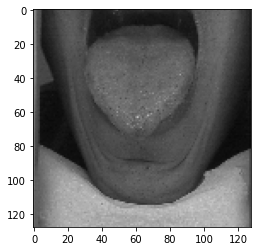

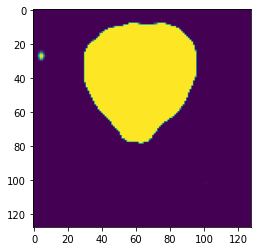

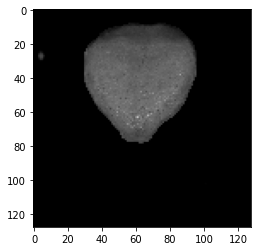

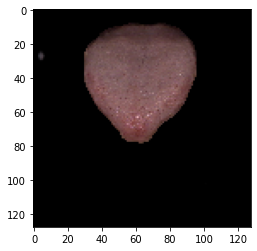

In [8]:
inference2("5.bmp")

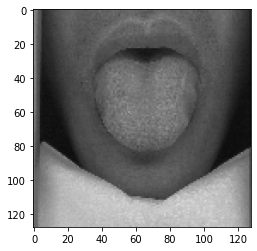

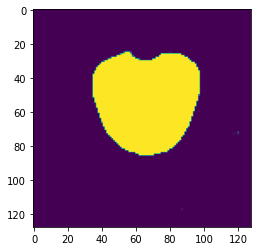

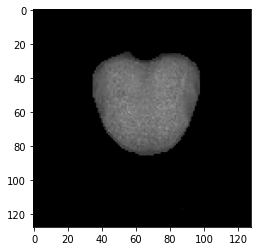

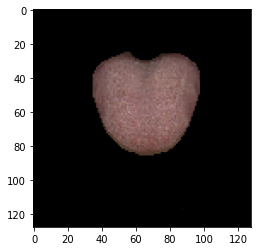

In [9]:
inference2("10.bmp")

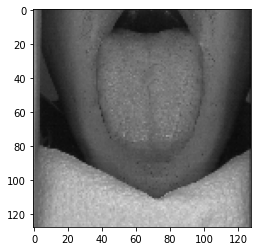

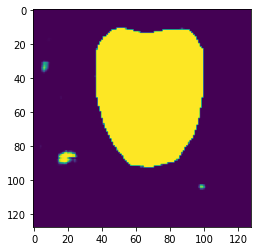

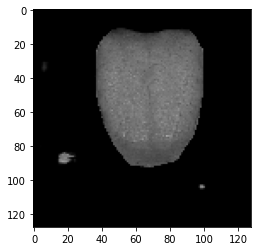

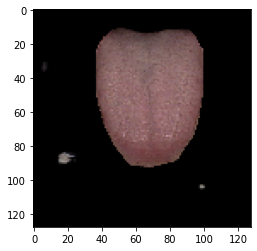

In [10]:
inference2("152.bmp")